In [251]:
import pandas as pd
import numpy as np
import geopandas as gpd
%matplotlib inline
#import shapely
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel,RationalQuadratic,Exponentiation,ExpSineSquared
from sklearn.mixture import GaussianMixture

In [2]:
tobacco = pd.read_csv('New_Classes.csv')

In [4]:
tobacco.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'id', u'BoroCT2010', u'n_report',
       u'DBN', u'school_distance', u'n_school', u'subway_distance',
       u'n_tobacco', u'Enrollment', u'Student Achievement Rating',
       u'Percent White', u'Percent Black', u'Percent Hispanic',
       u'Percent Asian', u'% Female', u'% Poverty', u'MHI',
       u'Total Population', u'type', u'latitude', u'longitude', u'class'],
      dtype='object')

In [58]:
df = tobacco[['class','n_report','school_distance','n_school','subway_distance',
             'n_tobacco', u'% Poverty', u'MHI',
       u'Total Population']]

In [59]:
df = df.dropna()

In [60]:
GM=GaussianMixture(n_components=4,random_state=999)
GM.fit(df.iloc[:,2:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [61]:
GM.predict(df.iloc[:,2:])

array([0, 2, 3, ..., 0, 0, 0], dtype=int64)

In [62]:
df['pred'] = GM.predict(df.iloc[:,2:])

In [63]:
df.groupby('pred').mean()['n_report']

pred
0    0.268654
1    0.271540
2    0.305234
3    0.231099
Name: n_report, dtype: float64

In [31]:
pd.DataFrame(GM.score_samples(df)).sort_values(0)[:5]

,0
3897,-96.191788
2837,-89.283790
10348,-89.151749
100,-89.137673
5775,-88.643727


In [29]:
tobacco.sort_values('n_report', ascending=False).head(10)

,Unnamed: 0,Unnamed: 0.1,id,BoroCT2010,n_report,DBN,school_distance,n_school,subway_distance,n_tobacco,...,Percent Hispanic,Percent Asian,% Female,% Poverty,MHI,Total Population,type,latitude,longitude,class
6672,6672,6672,12563,4011000,18.0,32K168,3693.208114,0.0,712.411294,5,...,0.399,0.026,0.373134,0.910448,46454,3075,GROCERY SUPERMARKET,40.687494,-73.834770,4
2627,2627,2627,14623,4055600,17.0,13K412,820.357229,0.0,666.709541,1,...,0.182,0.011,0.575198,0.799472,70214,2153,GROCERY SUPERMARKET,40.725223,-73.744630,4
6748,6748,6748,19222,3005300,16.0,20K609,1280.491633,0.0,2070.808317,10,...,0.174,0.477,1.000000,0.909263,68393,1888,CONVENIENCE STORE,40.674524,-74.007558,4
7521,7521,7521,16987,3082000,13.0,05M670,1206.240979,0.0,1081.135876,10,...,0.221,0.013,0.531876,0.699454,45943,5281,GROCERY SUPERMARKET,40.651926,-73.949737,4
9265,9265,9265,15684,1017000,12.0,09X324,1948.319619,2.0,903.490794,15,...,0.654,0.035,0.500000,0.789683,39611,7855,GROCERY SUPERMARKET,40.790402,-73.942554,4
9935,9935,9935,16288,5002002,11.0,84M353,1230.581340,0.0,53.417354,4,...,0.946,0.000,0.549407,0.905138,90000,3258,OTHER,40.597988,-74.066739,4
3816,3816,3816,15467,4004700,10.0,32K545,681.476885,0.0,1115.985664,4,...,0.896,0.006,0.453846,0.940385,33324,3984,GROCERY SUPERMARKET,40.761617,-73.931412,3
4932,4932,4932,16589,3037700,10.0,03M485,980.675307,1.0,662.657953,6,...,0.194,0.191,0.736823,0.296719,46584,3660,GROCERY SUPERMARKET,40.684254,-73.922950,3
9342,9342,9342,16894,1017800,10.0,84K517,1176.053985,0.0,749.327317,10,...,0.125,0.000,0.511658,0.779793,33705,3912,GROCERY SUPERMARKET,40.796342,-73.935114,3
9743,9743,9743,14992,1004800,9.0,24Q560,1241.229104,2.0,1977.715494,13,...,0.645,0.193,0.439807,0.797753,85556,7229,CONVENIENCE STORE,40.731846,-73.983674,3


# GP

In [209]:
df = tobacco[['n_report','longitude','latitude']].sort_values('n_report', ascending=False)

In [210]:
df.head()

,n_report,longitude,latitude
6672,18.0,-73.834770,40.687494
2627,17.0,-73.744630,40.725223
6748,16.0,-74.007558,40.674524
7521,13.0,-73.949737,40.651926
9265,12.0,-73.942554,40.790402


In [221]:
df1 = df[df.n_report>0]
len(df1)

1602

In [222]:
sample = df1.head(5000).copy()

In [241]:
sample['n_report']= (sample['n_report']).apply(np.log)
meanlog = sample.n_report.mean()
sample['n_report'] = sample.n_report - meanlog

In [242]:
sample.dropna(inplace=True)

In [243]:
X = np.array(sample[['longitude','latitude']])
y = np.array(sample.n_report)

In [244]:
kernel = 1.0 * RBF(30,(1e-2, 1e-2))\
            + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e10))
gp_rbf = GaussianProcessRegressor(kernel=kernel).fit(X, y)

In [245]:
h = 0.005
x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gp_rbf.predict(np.c_[xx.ravel(), yy.ravel()])

0.185**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=0.49)


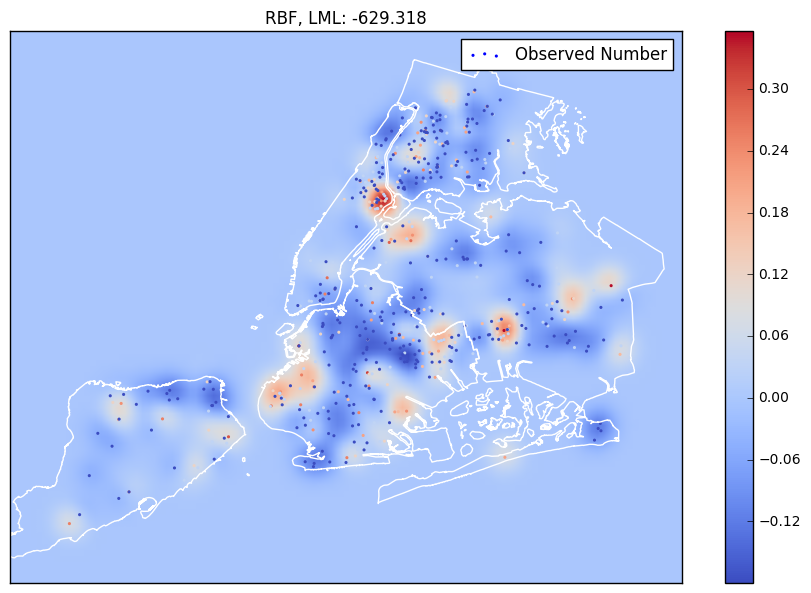

In [275]:
Z = Z.reshape((xx.shape[0], xx.shape[1]))
print gp_rbf.kernel_
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
nyc = gpd.read_file('NYC.geojson')
nyc.plot(ax=ax, facecolor='1', c='0.25', alpha=0, edgecolor='white')
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap='coolwarm')
plt.colorbar()
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp_rbf.log_marginal_likelihood(gp_rbf.kernel_.theta)))
plt.scatter(sample['longitude'], sample['latitude'], c=sample['n_report'], s=5, linewidth=0,
           cmap='coolwarm',alpha=1,label='Observed Number')
plt.legend()
plt.tight_layout()
#plt.axis('off')
plt.show()

In [277]:
tobacco['n_report'].sum()

2828.0

In [278]:
minor = pd.read_csv('minor.csv')

In [296]:
len(minor['Created Date'].apply(lambda x: x[:2]+x[6:10]).unique())/12

7

In [297]:
nc=pd.read_csv("New_Classes.csv")

In [299]:
pd.value_counts(nc['class'])

1    8934
2    1349
3     247
4       6
Name: class, dtype: int64

In [301]:
1394+247+6

1647